# **Homework 2 - Classification**
若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

Binary classification is one of the most fundamental problem in machine learning. In this tutorial, you are going to build linear binary classifiers to predict whether the income of an indivisual exceeds 50,000 or not. We presented a discriminative and a generative approaches, the logistic regression(LR) and the linear discriminant anaysis(LDA). You are encouraged to compare the differences between the two, or explore more methodologies. Although you can finish this tutorial by simpliy copying and pasting the codes, we strongly recommend you to understand the mathematical formulation first to get more insight into the two algorithms. Please find [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) and [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf) for more detailed information about the two algorithms.

二元分類是機器學習中最基礎的問題之一，在這份教學中，你將學會如何實作一個線性二元分類器，來根據人們的個人資料，判斷其年收入是否高於 50,000 美元。我們將以兩種方法: logistic regression 與 generative model，來達成以上目的，你可以嘗試了解、分析兩者的設計理念及差別。針對這兩個演算法的理論基礎，可以參考李宏毅老師的教學投影片 [logistic regression](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) 與 [generative model](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)。

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# Dataset

This dataset is obtained by removing unnecessary attributes and balancing the ratio between positively and negatively labeled data in the [**Census-Income (KDD) Data Set**](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)), which can be found in [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php). Only preprocessed and one-hot encoded data (i.e. *X_train*,  *Y_train* and *X_test*) will be used in this tutorial. Raw data (i.e. *train.csv* and *test.csv*) are provided to you in case you are interested in it.

這個資料集是由 [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php) 的 [**Census-Income (KDD) Data Set**](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)) 經過一些處理而得來。為了方便訓練，我們移除了一些不必要的資訊，並且稍微平衡了正負兩種標記的比例。事實上在訓練過程中，只有 X_train、Y_train 和 X_test 這三個經過處理的檔案會被使用到，train.csv 和 test.csv 這兩個原始資料檔則可以提供你一些額外的資訊。

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Preparing Data

Load and normalize data, and then split training data into training set and development set.

下載資料，並且對每個屬性做正規化，處理過後再將其切分為訓練集與發展集。

In [91]:
np.random.seed(0)
X_train_fpath = '../data/X_train'
Y_train_fpath = '../data/Y_train'
X_test_fpath = '../data/X_test'
output_fpath = '../results/output_{}.csv'

# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
    
# Split data into training set and development set
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510



### Some Useful Functions

Some functions that will be repeatedly used when iteratively updating the parameters.

這幾個函數可能會在訓練迴圈中被重複使用到。

In [3]:
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

def _f(X, w, b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w) + b)

def _predict(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return np.round(_f(X, w, b)).astype(np.int)
    
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

### Functions about gradient and loss

Please refers to [Prof. Lee's lecture slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)(p.12) for the formula of gradient and loss computation.

請參考[李宏毅老師上課投影片](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)第 12 頁的梯度及損失函數計算公式。

In [70]:
def _cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad


def _regulrization(X, Y_label, w, b, lamb):
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * (X@X.T + lamb*np.identity(X.shape[0])) @ X, 0) 
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad

### Progress bar

In [6]:
def _progress_bar(
    epoch,
    max_iter,
    percentage,
#     training_acc,
#     training_loss,
#     dev_acc,
#     dev_loss,
    block = 10
):
    if percentage == 100.:
        print('\r',
              '[Epoch %d/%d]:[%s]%.1f%%' % (epoch, max_iter, '█' * block, 100.0),
#               'training_acc: %.4f' % training_acc,
#               'training_loss: %.4f' % training_loss,
#               'dev_acc: %.4f' % dev_acc,
#               'dev_loss: %.4f' % dev_loss,
              ';\n\n',
              end = '')
    else:
        print('\r',
              '[Epoch %d/%d]:[%s%s]%.1f%%' % (epoch, max_iter,
                                           '█' * int(percentage*block/100),
                                           ' ' * (block-int(percentage*block/100)),
                                           float(percentage)),
              end = '')

---
## Problem 1

### Logistic Regression

Everything is prepared, let's start training! 

Mini-batch gradient descent is used here, in which training data are split into several mini-batches and each batch is fed into the model sequentially for losses and gradients computation. Weights and bias are updated on a mini-batch basis.

Once we have gone through the whole training set,  the data have to be re-shuffled and mini-batch gradient desent has to be run on it again. We repeat such process until max number of iterations is reached.

我們使用小批次梯度下降法來訓練。訓練資料被分為許多小批次，針對每一個小批次，我們分別計算其梯度以及損失，並根據該批次來更新模型的參數。當一次迴圈完成，也就是整個訓練集的所有小批次都被使用過一次以後，我們將所有訓練資料打散並且重新分成新的小批次，進行下一個迴圈，直到事先設定的迴圈數量達成為止。

In [92]:
# Zero initialization for weights ans bias
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# Some parameters for training    
max_iter = 500
batch_size = 500
learning_rate = 0.02

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Calcuate the number of parameter updates
step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)
        
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)
            
        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
        
        # progress bar
        if idx == int(np.floor(train_size / batch_size)) - 1:
            _progress_bar(epoch+1, max_iter, 100.)
        else:
            _progress_bar(epoch+1, max_iter, idx * batch_size * 100 / train_size)
            
    # Compute loss and accuracy of training set and development set
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)

    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

 [Epoch 1/500]:[██████████]100.0% ;

 [Epoch 2/500]:[██████████]100.0% ;

 [Epoch 3/500]:[██████████]100.0% ;

 [Epoch 4/500]:[██████████]100.0% ;

 [Epoch 5/500]:[██████████]100.0% ;

 [Epoch 6/500]:[██████████]100.0% ;

 [Epoch 7/500]:[██████████]100.0% ;

 [Epoch 8/500]:[██████████]100.0% ;

 [Epoch 9/500]:[██████████]100.0% ;

 [Epoch 10/500]:[██████████]100.0% ;

 [Epoch 11/500]:[██████████]100.0% ;

 [Epoch 12/500]:[██████████]100.0% ;

 [Epoch 13/500]:[██████████]100.0% ;

 [Epoch 14/500]:[██████████]100.0% ;

 [Epoch 15/500]:[██████████]100.0% ;

 [Epoch 16/500]:[██████████]100.0% ;

 [Epoch 17/500]:[██████████]100.0% ;

 [Epoch 18/500]:[██████████]100.0% ;

 [Epoch 19/500]:[██████████]100.0% ;

 [Epoch 20/500]:[██████████]100.0% ;

 [Epoch 21/500]:[██████████]100.0% ;

 [Epoch 22/500]:[██████████]100.0% ;

 [Epoch 23/500]:[██████████]100.0% ;

 [Epoch 24/500]:[██████████]100.0% ;

 [Epoch 25/500]:[██████████]100.0% ;

 [Epoch 26/500]:[██████████]100.0% ;

 [Epoch 27/500]:[████

 [Epoch 214/500]:[██████████]100.0% ;

 [Epoch 215/500]:[██████████]100.0% ;

 [Epoch 216/500]:[██████████]100.0% ;

 [Epoch 217/500]:[██████████]100.0% ;

 [Epoch 218/500]:[██████████]100.0% ;

 [Epoch 219/500]:[██████████]100.0% ;

 [Epoch 220/500]:[██████████]100.0% ;

 [Epoch 221/500]:[██████████]100.0% ;

 [Epoch 222/500]:[██████████]100.0% ;

 [Epoch 223/500]:[██████████]100.0% ;

 [Epoch 224/500]:[██████████]100.0% ;

 [Epoch 225/500]:[██████████]100.0% ;

 [Epoch 226/500]:[██████████]100.0% ;

 [Epoch 227/500]:[██████████]100.0% ;

 [Epoch 228/500]:[██████████]100.0% ;

 [Epoch 229/500]:[██████████]100.0% ;

 [Epoch 230/500]:[██████████]100.0% ;

 [Epoch 231/500]:[██████████]100.0% ;

 [Epoch 232/500]:[██████████]100.0% ;

 [Epoch 233/500]:[██████████]100.0% ;

 [Epoch 234/500]:[██████████]100.0% ;

 [Epoch 235/500]:[██████████]100.0% ;

 [Epoch 236/500]:[██████████]100.0% ;

 [Epoch 237/500]:[██████████]100.0% ;

 [Epoch 238/500]:[██████████]100.0% ;

 [Epoch 239/500]:[███████

 [Epoch 425/500]:[██████████]100.0% ;

 [Epoch 426/500]:[██████████]100.0% ;

 [Epoch 427/500]:[██████████]100.0% ;

 [Epoch 428/500]:[██████████]100.0% ;

 [Epoch 429/500]:[██████████]100.0% ;

 [Epoch 430/500]:[██████████]100.0% ;

 [Epoch 431/500]:[██████████]100.0% ;

 [Epoch 432/500]:[██████████]100.0% ;

 [Epoch 433/500]:[██████████]100.0% ;

 [Epoch 434/500]:[██████████]100.0% ;

 [Epoch 435/500]:[██████████]100.0% ;

 [Epoch 436/500]:[██████████]100.0% ;och 436/500]:[███████   ]77.8%

 [Epoch 437/500]:[██████████]100.0% ;

 [Epoch 438/500]:[██████████]100.0% ;

 [Epoch 439/500]:[██████████]100.0% ;

 [Epoch 440/500]:[██████████]100.0% ;och 440/500]:[█████     ]58.4%

 [Epoch 441/500]:[██████████]100.0% ;

 [Epoch 442/500]:[██████████]100.0% ;

 [Epoch 443/500]:[██████████]100.0% ;

 [Epoch 444/500]:[██████████]100.0% ;

 [Epoch 445/500]:[██████████]100.0% ;

 [Epoch 446/500]:[██████████]100.0% ;

 [Epoch 447/500]:[██████████]100.0% ;

 [Epoch 448/500]:[██████████]100.0% ;

 [Ep

### Plotting Loss and accuracy curve

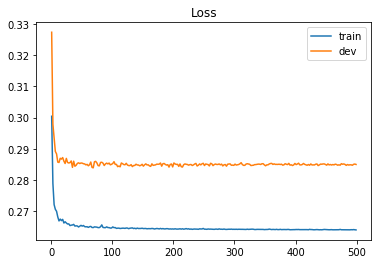

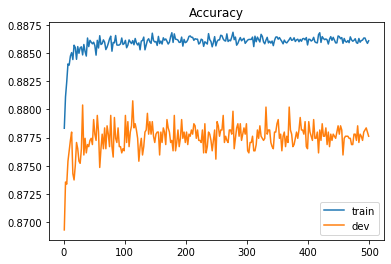

In [93]:
step = 2

# Loss curve
plt.plot(np.arange(0, len(train_acc), step) + 1, train_loss[::step])
plt.plot(np.arange(0, len(train_acc), step) + 1, dev_loss[::step])
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('./../fig/loss.png')
plt.show()

# Accuracy curve
plt.plot(np.arange(0, len(train_acc), step) + 1, train_acc[::step])
plt.plot(np.arange(0, len(train_acc), step) + 1, dev_acc[::step])
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('./../fig/acc.png')
plt.show()

## Test on validation

In [11]:
predictions = _predict(X_dev, w, b)

In [12]:
predictions = _predict(X_dev, w, b)
D_acc = _accuracy(predictions, Y_dev)
D_acc

0.8772576483597494

### Generative model training

### Preparing Data

Training and testing data is loaded and normalized as in logistic regression. However, since LDA is a deterministic algorithm, there is no need to build a development set.

訓練集與測試集的處理方法跟 logistic regression 一模一樣，然而因為 generative model 有可解析的最佳解，因此不必使用到 development set。

In [13]:
# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

### Mean and Covariance

In generative model, in-class mean and covariance are needed.

在 generative model 中，我們需要分別計算兩個類別內的資料平均與共變異。

In [14]:
# Compute in-class mean
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis = 0)
mean_1 = np.mean(X_train_1, axis = 0)  

# Compute in-class covariance
cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[0]

# Shared covariance is taken as a weighted average of individual in-class covariance.
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]) / (X_train_0.shape[0] + X_train_1.shape[0])

### Computing weights and bias

Directly compute weights and bias from in-class mean and shared variance. [Prof. Lee's lecture slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)(p.33) gives a concise explanation.

權重矩陣與偏差向量可以直接被計算出來，算法可以參考[李宏毅老師教學投影片](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)第 33 頁。

In [15]:
# Compute inverse of covariance matrix.
# Since covariance matrix may be nearly singular, np.linalg.inv() may give a large numerical error.
# Via SVD decomposition, one can get matrix inverse efficiently and accurately.
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# Directly compute weights and bias
w = np.dot(inv, mean_0 - mean_1)
b =  (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0]) 

# Compute accuracy on training set
Y_train_pred = 1 - _predict(X_train, w, b)
print('Training accuracy: {}'.format(_accuracy(Y_train_pred, Y_train)))

Training accuracy: 0.8747051017398997


In [16]:
Y_train_pred =  1 - _predict(X_train, w, b)
T_acc = _accuracy(Y_train_pred, Y_train)
T_acc

0.8747051017398997

In [18]:
y_dev_pred =  1 - _predict(X_dev, w, b)
D_acc = _accuracy(y_dev_pred, Y_dev)
D_acc

0.8720973092517508

## Problem 2

In [75]:
# Zero initialization for weights ans bias
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# Some parameters for training    
max_iter = 500
batch_size = 500
learning_rate = 0.02

# regularization
lamb_list = [0, 0.01, 0.1, 1]

lamb_train_loss = []
lamb_dev_loss = []
lamb_train_acc = []
lamb_dev_acc = []

lamb_w_list = []
lamb_b_list = []

for lamb in lamb_list:
    print("Using lambda =", lamb)
    
    # Keep the loss and accuracy at every iteration for plotting
    train_loss = []
    dev_loss = []
    train_acc = []
    dev_acc = []

    # Calcuate the number of parameter updates
    step = 1

    # Iterative training
    for epoch in range(max_iter):
        # Random shuffle at the begging of each epoch
        X_train, Y_train = _shuffle(X_train, Y_train)

        # Mini-batch training
        for idx in range(int(np.floor(train_size / batch_size))):
            X = X_train[idx*batch_size:(idx+1)*batch_size]
            Y = Y_train[idx*batch_size:(idx+1)*batch_size]

            # Compute the gradient
            w_grad, b_grad = _regulrization(X, Y, w, b, lamb)

            # gradient descent update
            # learning rate decay with time
            w = w - learning_rate/np.sqrt(step) * w_grad
            b = b - learning_rate/np.sqrt(step) * b_grad

            step = step + 1

            # progress bar
            if idx == int(np.floor(train_size / batch_size)) - 1:
                _progress_bar(epoch+1, max_iter, 100.)
            else:
                _progress_bar(epoch+1, max_iter, idx * batch_size * 100 / train_size)

        # Compute loss and accuracy of training set and development set
        y_train_pred = _f(X_train, w, b)
        Y_train_pred = np.round(y_train_pred)
        train_acc.append(_accuracy(Y_train_pred, Y_train))
        train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)

        y_dev_pred = _f(X_dev, w, b)
        Y_dev_pred = np.round(y_dev_pred)
        dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
        dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

    lamb_train_loss.append(train_loss)
    lamb_dev_loss.append(dev_loss)
    lamb_train_acc.append(train_acc)
    lamb_dev_acc.append(dev_acc)
    lamb_w_list.append(w)
    lamb_b_list.append(b)

Using lambda = 0
 [Epoch 1/500]:[██████████]100.0% ;

 [Epoch 2/500]:[██████████]100.0% ;

 [Epoch 3/500]:[██████████]100.0% ;

 [Epoch 4/500]:[██████████]100.0% ;

 [Epoch 5/500]:[██████████]100.0% ;

 [Epoch 6/500]:[██████████]100.0% ;

 [Epoch 7/500]:[██████████]100.0% ;

 [Epoch 8/500]:[██████████]100.0% ;

 [Epoch 9/500]:[██████████]100.0% ;

 [Epoch 10/500]:[██████████]100.0% ;

 [Epoch 11/500]:[██████████]100.0% ;

 [Epoch 12/500]:[██████████]100.0% ;

 [Epoch 13/500]:[██████████]100.0% ;

 [Epoch 14/500]:[██████████]100.0% ;

 [Epoch 15/500]:[██████████]100.0% ;

 [Epoch 16/500]:[██████████]100.0% ;

 [Epoch 17/500]:[██████████]100.0% ;

 [Epoch 18/500]:[██████████]100.0% ;

 [Epoch 19/500]:[██████████]100.0% ;

 [Epoch 20/500]:[██████████]100.0% ;

 [Epoch 21/500]:[██████████]100.0% ;

 [Epoch 22/500]:[██████████]100.0% ;

 [Epoch 23/500]:[██████████]100.0% ;

 [Epoch 24/500]:[██████████]100.0% ;

 [Epoch 25/500]:[██████████]100.0% ;

 [Epoch 26/500]:[██████████]100.0% ;

 [Ep

 [Epoch 205/500]:[██████████]100.0% ;

 [Epoch 206/500]:[██████████]100.0% ;

 [Epoch 207/500]:[██████████]100.0% ;

 [Epoch 208/500]:[██████████]100.0% ;

 [Epoch 209/500]:[██████████]100.0% ;

 [Epoch 210/500]:[██████████]100.0% ;

 [Epoch 211/500]:[██████████]100.0% ;

 [Epoch 212/500]:[██████████]100.0% ;

 [Epoch 213/500]:[██████████]100.0% ;

 [Epoch 214/500]:[██████████]100.0% ;och 214/500]:[██████    ]67.6%

 [Epoch 215/500]:[██████████]100.0% ;

 [Epoch 216/500]:[██████████]100.0% ;

 [Epoch 217/500]:[██████████]100.0% ;

 [Epoch 218/500]:[██████████]100.0% ;

 [Epoch 219/500]:[██████████]100.0% ;

 [Epoch 220/500]:[██████████]100.0% ;

 [Epoch 221/500]:[██████████]100.0% ;

 [Epoch 222/500]:[██████████]100.0% ;

 [Epoch 223/500]:[██████████]100.0% ;

 [Epoch 224/500]:[██████████]100.0% ;

 [Epoch 225/500]:[██████████]100.0% ;

 [Epoch 226/500]:[██████████]100.0% ;

 [Epoch 227/500]:[██████████]100.0% ;

 [Epoch 228/500]:[██████████]100.0% ;

 [Epoch 229/500]:[██████████]100.0

 [Epoch 411/500]:[██████████]100.0% ;

 [Epoch 412/500]:[██████████]100.0% ;

 [Epoch 413/500]:[██████████]100.0% ;

 [Epoch 414/500]:[██████████]100.0% ;

 [Epoch 415/500]:[██████████]100.0% ;

 [Epoch 416/500]:[██████████]100.0% ;

 [Epoch 417/500]:[██████████]100.0% ;

 [Epoch 418/500]:[██████████]100.0% ;

 [Epoch 419/500]:[██████████]100.0% ;

 [Epoch 420/500]:[██████████]100.0% ;

 [Epoch 421/500]:[██████████]100.0% ;

 [Epoch 422/500]:[██████████]100.0% ;

 [Epoch 423/500]:[██████████]100.0% ;

 [Epoch 424/500]:[██████████]100.0% ;

 [Epoch 425/500]:[██████████]100.0% ;

 [Epoch 426/500]:[██████████]100.0% ;

 [Epoch 427/500]:[██████████]100.0% ;

 [Epoch 428/500]:[██████████]100.0% ;

 [Epoch 429/500]:[██████████]100.0% ;

 [Epoch 430/500]:[██████████]100.0% ;

 [Epoch 431/500]:[██████████]100.0% ;

 [Epoch 432/500]:[██████████]100.0% ;

 [Epoch 433/500]:[██████████]100.0% ;

 [Epoch 434/500]:[██████████]100.0% ;

 [Epoch 435/500]:[██████████]100.0% ;

 [Epoch 436/500]:[███████

 [Epoch 116/500]:[██████████]100.0% ;

 [Epoch 117/500]:[██████████]100.0% ;

 [Epoch 118/500]:[██████████]100.0% ;

 [Epoch 119/500]:[██████████]100.0% ;

 [Epoch 120/500]:[██████████]100.0% ;

 [Epoch 121/500]:[██████████]100.0% ;och 121/500]:[████      ]43.0%

 [Epoch 122/500]:[██████████]100.0% ;

 [Epoch 123/500]:[██████████]100.0% ;

 [Epoch 124/500]:[██████████]100.0% ;

 [Epoch 125/500]:[██████████]100.0% ;

 [Epoch 126/500]:[██████████]100.0% ;

 [Epoch 127/500]:[██████████]100.0% ;

 [Epoch 128/500]:[██████████]100.0% ;

 [Epoch 129/500]:[██████████]100.0% ;och 129/500]:[██████    ]61.4%

 [Epoch 130/500]:[██████████]100.0% ;

 [Epoch 131/500]:[██████████]100.0% ;

 [Epoch 132/500]:[██████████]100.0% ;

 [Epoch 133/500]:[██████████]100.0% ;

 [Epoch 134/500]:[██████████]100.0% ;

 [Epoch 135/500]:[██████████]100.0% ;

 [Epoch 136/500]:[██████████]100.0% ;

 [Epoch 137/500]:[██████████]100.0% ;och 137/500]:[██████    ]65.5%

 [Epoch 138/500]:[██████████]100.0% ;

 [Epoch 139/5

 [Epoch 317/500]:[██████████]100.0% ;

 [Epoch 318/500]:[██████████]100.0% ;

 [Epoch 319/500]:[██████████]100.0% ;

 [Epoch 320/500]:[██████████]100.0% ;

 [Epoch 321/500]:[██████████]100.0% ;

 [Epoch 322/500]:[██████████]100.0% ;

 [Epoch 323/500]:[██████████]100.0% ;

 [Epoch 324/500]:[██████████]100.0% ;

 [Epoch 325/500]:[██████████]100.0% ;

 [Epoch 326/500]:[██████████]100.0% ;och 326/500]:[██████    ]63.5%

 [Epoch 327/500]:[██████████]100.0% ;

 [Epoch 328/500]:[██████████]100.0% ;

 [Epoch 329/500]:[██████████]100.0% ;och 329/500]:[██████    ]65.5%

 [Epoch 330/500]:[██████████]100.0% ;

 [Epoch 331/500]:[██████████]100.0% ;

 [Epoch 332/500]:[██████████]100.0% ;

 [Epoch 333/500]:[██████████]100.0% ;och 333/500]:[███████   ]77.8%

 [Epoch 334/500]:[██████████]100.0% ;

 [Epoch 335/500]:[██████████]100.0% ;

 [Epoch 336/500]:[██████████]100.0% ;

 [Epoch 337/500]:[██████████]100.0% ;

 [Epoch 338/500]:[██████████]100.0% ;

 [Epoch 339/500]:[██████████]100.0% ;

 [Epoch 340/5

 [Epoch 18/500]:[██████████]100.0% ;

 [Epoch 19/500]:[██████████]100.0% ;

 [Epoch 20/500]:[██████████]100.0% ;

 [Epoch 21/500]:[██████████]100.0% ;

 [Epoch 22/500]:[██████████]100.0% ;

 [Epoch 23/500]:[██████████]100.0% ;

 [Epoch 24/500]:[██████████]100.0% ;

 [Epoch 25/500]:[██████████]100.0% ;

 [Epoch 26/500]:[██████████]100.0% ;

 [Epoch 27/500]:[██████████]100.0% ;

 [Epoch 28/500]:[██████████]100.0% ;

 [Epoch 29/500]:[██████████]100.0% ;

 [Epoch 30/500]:[██████████]100.0% ;

 [Epoch 31/500]:[██████████]100.0% ;

 [Epoch 32/500]:[██████████]100.0% ;

 [Epoch 33/500]:[██████████]100.0% ;och 33/500]:[███████   ]72.7%

 [Epoch 34/500]:[██████████]100.0% ;

 [Epoch 35/500]:[██████████]100.0% ;

 [Epoch 36/500]:[██████████]100.0% ;

 [Epoch 37/500]:[██████████]100.0% ;

 [Epoch 38/500]:[██████████]100.0% ;

 [Epoch 39/500]:[██████████]100.0% ;

 [Epoch 40/500]:[██████████]100.0% ;

 [Epoch 41/500]:[██████████]100.0% ;

 [Epoch 42/500]:[██████████]100.0% ;

 [Epoch 43/500]:[████

 [Epoch 227/500]:[██████████]100.0% ;

 [Epoch 228/500]:[██████████]100.0% ;

 [Epoch 229/500]:[██████████]100.0% ;

 [Epoch 230/500]:[██████████]100.0% ;

 [Epoch 231/500]:[██████████]100.0% ;

 [Epoch 232/500]:[██████████]100.0% ;

 [Epoch 233/500]:[██████████]100.0% ;

 [Epoch 234/500]:[██████████]100.0% ;

 [Epoch 235/500]:[██████████]100.0% ;

 [Epoch 236/500]:[██████████]100.0% ;

 [Epoch 237/500]:[██████████]100.0% ;

 [Epoch 238/500]:[██████████]100.0% ;

 [Epoch 239/500]:[██████████]100.0% ;

 [Epoch 240/500]:[██████████]100.0% ;

 [Epoch 241/500]:[██████████]100.0% ;

 [Epoch 242/500]:[██████████]100.0% ;

 [Epoch 243/500]:[██████████]100.0% ;och 243/500]:[█         ]17.4%

 [Epoch 244/500]:[██████████]100.0% ;

 [Epoch 245/500]:[██████████]100.0% ;

 [Epoch 246/500]:[██████████]100.0% ;

 [Epoch 247/500]:[██████████]100.0% ;

 [Epoch 248/500]:[██████████]100.0% ;

 [Epoch 249/500]:[██████████]100.0% ;

 [Epoch 250/500]:[██████████]100.0% ;

 [Epoch 251/500]:[██████████]100.0

 [Epoch 433/500]:[██████████]100.0% ;

 [Epoch 434/500]:[██████████]100.0% ;

 [Epoch 435/500]:[██████████]100.0% ;

 [Epoch 436/500]:[██████████]100.0% ;

 [Epoch 437/500]:[██████████]100.0% ;

 [Epoch 438/500]:[██████████]100.0% ;och 438/500]:[███████   ]71.7%

 [Epoch 439/500]:[██████████]100.0% ;

 [Epoch 440/500]:[██████████]100.0% ;

 [Epoch 441/500]:[██████████]100.0% ;

 [Epoch 442/500]:[██████████]100.0% ;

 [Epoch 443/500]:[██████████]100.0% ;

 [Epoch 444/500]:[██████████]100.0% ;

 [Epoch 445/500]:[██████████]100.0% ;

 [Epoch 446/500]:[██████████]100.0% ;

 [Epoch 447/500]:[██████████]100.0% ;

 [Epoch 448/500]:[██████████]100.0% ;

 [Epoch 449/500]:[██████████]100.0% ;

 [Epoch 450/500]:[██████████]100.0% ;

 [Epoch 451/500]:[██████████]100.0% ;

 [Epoch 452/500]:[██████████]100.0% ;

 [Epoch 453/500]:[██████████]100.0% ;

 [Epoch 454/500]:[██████████]100.0% ;

 [Epoch 455/500]:[██████████]100.0% ;

 [Epoch 456/500]:[██████████]100.0% ;

 [Epoch 457/500]:[██████████]100.0

 [Epoch 138/500]:[██████████]100.0% ;

 [Epoch 139/500]:[██████████]100.0% ;

 [Epoch 140/500]:[██████████]100.0% ;och 140/500]:[█████████ ]92.2%

 [Epoch 141/500]:[██████████]100.0% ;

 [Epoch 142/500]:[██████████]100.0% ;

 [Epoch 143/500]:[██████████]100.0% ;

 [Epoch 144/500]:[██████████]100.0% ;

 [Epoch 145/500]:[██████████]100.0% ;

 [Epoch 146/500]:[██████████]100.0% ;

 [Epoch 147/500]:[██████████]100.0% ;

 [Epoch 148/500]:[██████████]100.0% ;

 [Epoch 149/500]:[██████████]100.0% ;

 [Epoch 150/500]:[██████████]100.0% ;och 150/500]:[██        ]22.5%

 [Epoch 151/500]:[██████████]100.0% ;

 [Epoch 152/500]:[██████████]100.0% ;

 [Epoch 153/500]:[██████████]100.0% ;

 [Epoch 154/500]:[██████████]100.0% ;

 [Epoch 155/500]:[██████████]100.0% ;

 [Epoch 156/500]:[██████████]100.0% ;

 [Epoch 157/500]:[██████████]100.0% ;

 [Epoch 158/500]:[██████████]100.0% ;

 [Epoch 159/500]:[██████████]100.0% ;

 [Epoch 160/500]:[██████████]100.0% ;

 [Epoch 161/500]:[██████████]100.0% ;

 [Ep

 [Epoch 346/500]:[██████████]100.0% ;

 [Epoch 347/500]:[██████████]100.0% ;

 [Epoch 348/500]:[██████████]100.0% ;

 [Epoch 349/500]:[██████████]100.0% ;

 [Epoch 350/500]:[██████████]100.0% ;

 [Epoch 351/500]:[██████████]100.0% ;

 [Epoch 352/500]:[██████████]100.0% ;

 [Epoch 353/500]:[██████████]100.0% ;

 [Epoch 354/500]:[██████████]100.0% ;

 [Epoch 355/500]:[██████████]100.0% ;

 [Epoch 356/500]:[██████████]100.0% ;

 [Epoch 357/500]:[██████████]100.0% ;

 [Epoch 358/500]:[██████████]100.0% ;

 [Epoch 359/500]:[██████████]100.0% ;

 [Epoch 360/500]:[██████████]100.0% ;

 [Epoch 361/500]:[██████████]100.0% ;

 [Epoch 362/500]:[██████████]100.0% ;

 [Epoch 363/500]:[██████████]100.0% ;

 [Epoch 364/500]:[██████████]100.0% ;

 [Epoch 365/500]:[██████████]100.0% ;

 [Epoch 366/500]:[██████████]100.0% ;

 [Epoch 367/500]:[██████████]100.0% ;

 [Epoch 368/500]:[██████████]100.0% ;

 [Epoch 369/500]:[██████████]100.0% ;

 [Epoch 370/500]:[██████████]100.0% ;

 [Epoch 371/500]:[███████

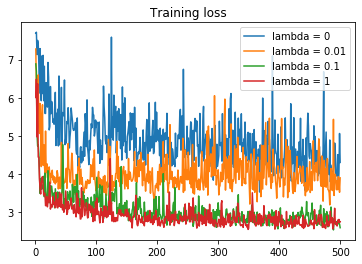

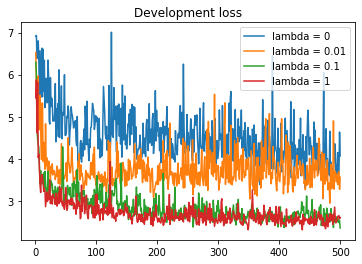

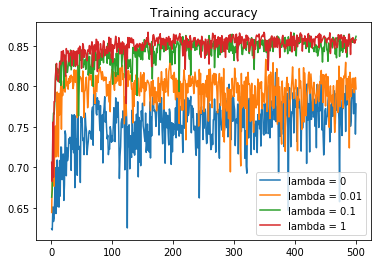

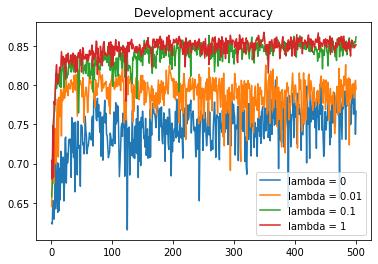

In [97]:
step = 1

# Loss curve
for i in range(len(lamb_list)):
    train_loss = lamb_train_loss[i]
    plt.plot(np.arange(0, len(train_loss), step) + 1, train_loss[::step], label = 'lambda = ' + str(lamb_list[i]))
plt.title('Training loss')
plt.legend(loc = 'upper right')
plt.savefig('./../fig/lambda_train_loss.png')
plt.show()

for i in range(len(lamb_list)):
    dev_loss = lamb_dev_loss[i]
    plt.plot(np.arange(0, len(dev_loss), step) + 1, dev_loss[::step], label = 'lambda = ' + str(lamb_list[i]))
plt.title('Development loss')
plt.legend(loc = 'upper right')
plt.savefig('./../fig/lambda_dev_loss.png')
plt.show()


for i in range(len(lamb_list)):
    train_acc = lamb_train_acc[i]
    plt.plot(np.arange(0, len(train_acc), step) + 1, train_acc[::step], label = 'lambda = ' + str(lamb_list[i]))
plt.title('Training accuracy')
plt.legend()
plt.savefig('./../fig/lambda_train_acc.png')
plt.show()

for i in range(len(lamb_list)):
    dev_acc = lamb_dev_acc[i]
    plt.plot(np.arange(0, len(train_acc), step) + 1, dev_acc[::step], label = 'lambda = ' + str(lamb_list[i]))
plt.title('Development accuracy')
plt.legend()
plt.savefig('./../fig/lambda_dev_acc.png')
plt.show()

In [84]:
for i in range(len(lamb_list)):
    train_acc = lamb_train_acc[i]
    dev_acc = lamb_dev_acc[i]
    print("lambda =", lamb_list[i], ", best train:", np.max(np.array(train_acc)), ", best dev:", np.max(np.array(dev_acc)))

lambda = 0 , best train: 0.8169971984665291 , best dev: 0.8074087725764836
lambda = 0.01 , best train: 0.8334009141846064 , best dev: 0.8260228529303354
lambda = 0.1 , best train: 0.865876585078148 , best dev: 0.8632510136380391
lambda = 1 , best train: 0.8669087289884989 , best dev: 0.8673055657943236


## Problem 4

In [104]:
# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
    
# Normalize training and testing data
norm_X_train, X_mean, X_std = _normalize(X_train, train = True)
norm_X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
    
# Split data into training set and development set
dev_ratio = 0.1
norm_X_train, norm_Y_train, norm_X_dev, norm_Y_dev = _train_dev_split(norm_X_train, Y_train, dev_ratio = dev_ratio)

# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

# Split data into training set and development set
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

In [105]:
# Zero initialization for weights ans bias
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# Some parameters for training    
max_iter = 500
batch_size = 500
learning_rate = 0.02

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Calcuate the number of parameter updates
step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)
        
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)
            
        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
        
        # progress bar
        if idx == int(np.floor(train_size / batch_size)) - 1:
            _progress_bar(epoch+1, max_iter, 100.)
        else:
            _progress_bar(epoch+1, max_iter, idx * batch_size * 100 / train_size)
            
    # Compute loss and accuracy of training set and development set
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)

    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

 [Epoch 1/500]:[██████████]100.0% ;

 [Epoch 2/500]:[██████████]100.0% ;

 [Epoch 3/500]:[██████████]100.0% ;

 [Epoch 4/500]:[██████████]100.0% ;

 [Epoch 5/500]:[██████████]100.0% ;

 [Epoch 6/500]:[██████████]100.0% ;

 [Epoch 7/500]:[██████████]100.0% ;

 [Epoch 8/500]:[██████████]100.0% ;

 [Epoch 9/500]:[██████████]100.0% ;

 [Epoch 10/500]:[██████████]100.0% ;

 [Epoch 11/500]:[██████████]100.0% ;

 [Epoch 12/500]:[██████████]100.0% ;

 [Epoch 13/500]:[██████████]100.0% ;

 [Epoch 14/500]:[██████████]100.0% ;

 [Epoch 15/500]:[██████████]100.0% ;

 [Epoch 16/500]:[██████████]100.0% ;

 [Epoch 17/500]:[██████████]100.0% ;

 [Epoch 18/500]:[██████████]100.0% ;

 [Epoch 19/500]:[██████████]100.0% ;

 [Epoch 20/500]:[██████████]100.0% ;

 [Epoch 21/500]:[██████████]100.0% ;

 [Epoch 22/500]:[██████████]100.0% ;

 [Epoch 23/500]:[██████████]100.0% ;

 [Epoch 24/500]:[██████████]100.0% ;

 [Epoch 25/500]:[██████████]100.0% ;

 [Epoch 26/500]:[██████████]100.0% ;

 [Epoch 27/500]:[████

 [Epoch 211/500]:[██████████]100.0% ;

 [Epoch 212/500]:[██████████]100.0% ;

 [Epoch 213/500]:[██████████]100.0% ;

 [Epoch 214/500]:[██████████]100.0% ;

 [Epoch 215/500]:[██████████]100.0% ;

 [Epoch 216/500]:[██████████]100.0% ;

 [Epoch 217/500]:[██████████]100.0% ;

 [Epoch 218/500]:[██████████]100.0% ;

 [Epoch 219/500]:[██████████]100.0% ;

 [Epoch 220/500]:[██████████]100.0% ;

 [Epoch 221/500]:[██████████]100.0% ;

 [Epoch 222/500]:[██████████]100.0% ;

 [Epoch 223/500]:[██████████]100.0% ;

 [Epoch 224/500]:[██████████]100.0% ;

 [Epoch 225/500]:[██████████]100.0% ;

 [Epoch 226/500]:[██████████]100.0% ;

 [Epoch 227/500]:[██████████]100.0% ;

 [Epoch 228/500]:[██████████]100.0% ;

 [Epoch 229/500]:[██████████]100.0% ;

 [Epoch 230/500]:[██████████]100.0% ;

 [Epoch 231/500]:[██████████]100.0% ;

 [Epoch 232/500]:[██████████]100.0% ;

 [Epoch 233/500]:[██████████]100.0% ;

 [Epoch 234/500]:[██████████]100.0% ;

 [Epoch 235/500]:[██████████]100.0% ;

 [Epoch 236/500]:[███████

 [Epoch 417/500]:[██████████]100.0% ;

 [Epoch 418/500]:[██████████]100.0% ;

 [Epoch 419/500]:[██████████]100.0% ;

 [Epoch 420/500]:[██████████]100.0% ;

 [Epoch 421/500]:[██████████]100.0% ;

 [Epoch 422/500]:[██████████]100.0% ;

 [Epoch 423/500]:[██████████]100.0% ;

 [Epoch 424/500]:[██████████]100.0% ;

 [Epoch 425/500]:[██████████]100.0% ;

 [Epoch 426/500]:[██████████]100.0% ;

 [Epoch 427/500]:[██████████]100.0% ;

 [Epoch 428/500]:[██████████]100.0% ;

 [Epoch 429/500]:[██████████]100.0% ;

 [Epoch 430/500]:[██████████]100.0% ;

 [Epoch 431/500]:[██████████]100.0% ;

 [Epoch 432/500]:[██████████]100.0% ;

 [Epoch 433/500]:[██████████]100.0% ;

 [Epoch 434/500]:[██████████]100.0% ;

 [Epoch 435/500]:[██████████]100.0% ;

 [Epoch 436/500]:[██████████]100.0% ;

 [Epoch 437/500]:[██████████]100.0% ;

 [Epoch 438/500]:[██████████]100.0% ;

 [Epoch 439/500]:[██████████]100.0% ;

 [Epoch 440/500]:[██████████]100.0% ;

 [Epoch 441/500]:[██████████]100.0% ;

 [Epoch 442/500]:[███████

In [106]:
# Zero initialization for weights ans bias
norm_w = np.zeros((data_dim,)) 
norm_b = np.zeros((1,))

# Some parameters for training    
max_iter = 500
batch_size = 500
learning_rate = 0.02

# Keep the loss and accuracy at every iteration for plotting
norm_train_loss = []
norm_dev_loss = []
norm_train_acc = []
norm_dev_acc = []

# Calcuate the number of parameter updates
step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    norm_X_train, norm_Y_train = _shuffle(norm_X_train, norm_Y_train)
        
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        norm_X = norm_X_train[idx*batch_size:(idx+1)*batch_size]
        norm_Y = norm_Y_train[idx*batch_size:(idx+1)*batch_size]

        # Compute the gradient
        norm_w_grad, norm_b_grad = _gradient(norm_X, norm_Y, norm_w, norm_b)
            
        # gradient descent update
        # learning rate decay with time
        norm_w = norm_w - learning_rate/np.sqrt(step) * norm_w_grad
        norm_b = norm_b - learning_rate/np.sqrt(step) * norm_b_grad

        step = step + 1
        
        # progress bar
        if idx == int(np.floor(train_size / batch_size)) - 1:
            _progress_bar(epoch+1, max_iter, 100.)
        else:
            _progress_bar(epoch+1, max_iter, idx * batch_size * 100 / train_size)
            
    # Compute loss and accuracy of training set and development set
    norm_y_train_pred = _f(norm_X_train, norm_w, norm_b)
    norm_Y_train_pred = np.round(norm_y_train_pred)
    norm_train_acc.append(_accuracy(norm_Y_train_pred, norm_Y_train))
    norm_train_loss.append(_cross_entropy_loss(norm_y_train_pred, norm_Y_train) / train_size)

    norm_y_dev_pred = _f(norm_X_dev, norm_w, norm_b)
    norm_Y_dev_pred = np.round(norm_y_dev_pred)
    norm_dev_acc.append(_accuracy(norm_Y_dev_pred, norm_Y_dev))
    norm_dev_loss.append(_cross_entropy_loss(norm_y_dev_pred, norm_Y_dev) / dev_size)

 [Epoch 1/500]:[██████████]100.0% ;

 [Epoch 2/500]:[██████████]100.0% ;

 [Epoch 3/500]:[██████████]100.0% ;

 [Epoch 4/500]:[██████████]100.0% ;

 [Epoch 5/500]:[██████████]100.0% ;

 [Epoch 6/500]:[██████████]100.0% ;

 [Epoch 7/500]:[██████████]100.0% ;

 [Epoch 8/500]:[██████████]100.0% ;

 [Epoch 9/500]:[██████████]100.0% ;

 [Epoch 10/500]:[██████████]100.0% ;

 [Epoch 11/500]:[██████████]100.0% ;

 [Epoch 12/500]:[██████████]100.0% ;

 [Epoch 13/500]:[██████████]100.0% ;

 [Epoch 14/500]:[██████████]100.0% ;

 [Epoch 15/500]:[██████████]100.0% ;

 [Epoch 16/500]:[██████████]100.0% ;

 [Epoch 17/500]:[██████████]100.0% ;

 [Epoch 18/500]:[██████████]100.0% ;

 [Epoch 19/500]:[██████████]100.0% ;

 [Epoch 20/500]:[██████████]100.0% ;

 [Epoch 21/500]:[██████████]100.0% ;

 [Epoch 22/500]:[██████████]100.0% ;

 [Epoch 23/500]:[██████████]100.0% ;

 [Epoch 24/500]:[██████████]100.0% ;

 [Epoch 25/500]:[██████████]100.0% ;

 [Epoch 26/500]:[██████████]100.0% ;

 [Epoch 27/500]:[████

 [Epoch 211/500]:[██████████]100.0% ;

 [Epoch 212/500]:[██████████]100.0% ;

 [Epoch 213/500]:[██████████]100.0% ;

 [Epoch 214/500]:[██████████]100.0% ;

 [Epoch 215/500]:[██████████]100.0% ;

 [Epoch 216/500]:[██████████]100.0% ;

 [Epoch 217/500]:[██████████]100.0% ;

 [Epoch 218/500]:[██████████]100.0% ;

 [Epoch 219/500]:[██████████]100.0% ;

 [Epoch 220/500]:[██████████]100.0% ;

 [Epoch 221/500]:[██████████]100.0% ;

 [Epoch 222/500]:[██████████]100.0% ;

 [Epoch 223/500]:[██████████]100.0% ;

 [Epoch 224/500]:[██████████]100.0% ;

 [Epoch 225/500]:[██████████]100.0% ;

 [Epoch 226/500]:[██████████]100.0% ;

 [Epoch 227/500]:[██████████]100.0% ;

 [Epoch 228/500]:[██████████]100.0% ;

 [Epoch 229/500]:[██████████]100.0% ;

 [Epoch 230/500]:[██████████]100.0% ;

 [Epoch 231/500]:[██████████]100.0% ;

 [Epoch 232/500]:[██████████]100.0% ;

 [Epoch 233/500]:[██████████]100.0% ;

 [Epoch 234/500]:[██████████]100.0% ;

 [Epoch 235/500]:[██████████]100.0% ;

 [Epoch 236/500]:[███████

 [Epoch 422/500]:[██████████]100.0% ;

 [Epoch 423/500]:[██████████]100.0% ;

 [Epoch 424/500]:[██████████]100.0% ;

 [Epoch 425/500]:[██████████]100.0% ;

 [Epoch 426/500]:[██████████]100.0% ;

 [Epoch 427/500]:[██████████]100.0% ;

 [Epoch 428/500]:[██████████]100.0% ;

 [Epoch 429/500]:[██████████]100.0% ;

 [Epoch 430/500]:[██████████]100.0% ;

 [Epoch 431/500]:[██████████]100.0% ;

 [Epoch 432/500]:[██████████]100.0% ;

 [Epoch 433/500]:[██████████]100.0% ;

 [Epoch 434/500]:[██████████]100.0% ;

 [Epoch 435/500]:[██████████]100.0% ;

 [Epoch 436/500]:[██████████]100.0% ;

 [Epoch 437/500]:[██████████]100.0% ;

 [Epoch 438/500]:[██████████]100.0% ;

 [Epoch 439/500]:[██████████]100.0% ;

 [Epoch 440/500]:[██████████]100.0% ;

 [Epoch 441/500]:[██████████]100.0% ;

 [Epoch 442/500]:[██████████]100.0% ;

 [Epoch 443/500]:[██████████]100.0% ;

 [Epoch 444/500]:[██████████]100.0% ;

 [Epoch 445/500]:[██████████]100.0% ;

 [Epoch 446/500]:[██████████]100.0% ;

 [Epoch 447/500]:[███████

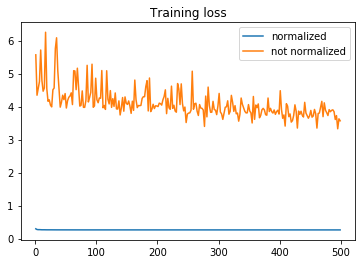

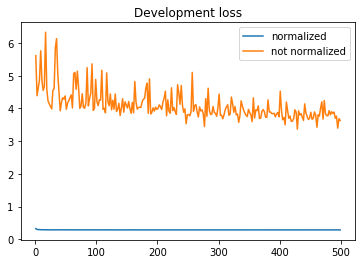

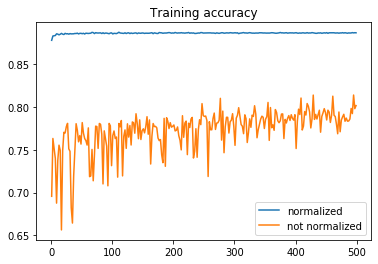

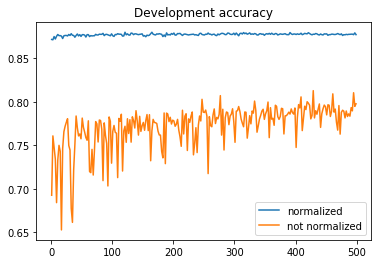

In [109]:
step = 2

# Loss curve
plt.plot(np.arange(0, len(norm_train_acc), step) + 1, norm_train_loss[::step])
plt.plot(np.arange(0, len(train_acc), step) + 1, train_loss[::step])
plt.title('Training loss')
plt.legend(['normalized', 'not normalized'])
plt.savefig('./../fig/norm_no_norm_train_loss.png')
plt.show()

plt.plot(np.arange(0, len(norm_train_acc), step) + 1, norm_dev_loss[::step])
plt.plot(np.arange(0, len(train_acc), step) + 1, dev_loss[::step])
plt.title('Development loss')
plt.legend(['normalized', 'not normalized'])
plt.savefig('./../fig/norm_no_norm_dev_loss.png')
plt.show()

# Accuracy curve
plt.plot(np.arange(0, len(norm_train_acc), step) + 1, norm_train_acc[::step])
plt.plot(np.arange(0, len(train_acc), step) + 1, train_acc[::step])
plt.title('Training accuracy')
plt.legend(['normalized', 'not normalized'])
plt.savefig('./../fig/norm_no_norm_train_acc.png')
plt.show()

plt.plot(np.arange(0, len(norm_train_acc), step) + 1, norm_dev_acc[::step])
plt.plot(np.arange(0, len(train_acc), step) + 1, dev_acc[::step])
plt.title('Development accuracy')
plt.legend(['normalized', 'not normalized'])
plt.savefig('./../fig/norm_no_norm_dev_acc.png')
plt.show()

In [110]:
print("Normalize, best train:", np.max(np.array(norm_train_acc)), ", best dev:", np.max(np.array(norm_dev_acc)))
print("No normalize, best train:", np.max(np.array(train_acc)), ", best dev:", np.max(np.array(dev_acc)))


Normalize, best train: 0.8869752201515462 , best dev: 0.8800221157390343
No normalize, best train: 0.819148064714315 , best dev: 0.8186509399189089
